# Applied Machine Learning (CS 5394) Lab #1 <br>
**Names:** Jiayi Zhu, Alex Glover, Yuanchun Zhao

In this notebook, we will be using 60 years of historical data to predict the world population in 2122. <br>

**Business Case:** Our team is attempting to develop a prediction model that will be able to estimate the world population for many years to come, specifically the year 2122 for this assignment. Population prediction is an important field that has been relied on to provide approximate but useful information about the future. The target market for these prediction models are policymakers, researchers, government officials, program planners, ect. Our model’s intended use includes but is not limited to helping forecast future demographic characteristics, future economy and economic trends, and the demands of the future population. Also, knowing the size of the population can be very useful when making decisions that will affect our world's resources. For example, with an increase in population also comes an increase in the demand of housing. A good population estimate could help accurately plan land usage and housing for a given year. <br>

**Dataset:** The dataset we will use in this notebook is a population dataset from the World Bank. It includes total population of the world for the last 60 years as well as total population for the time range broken down by country. <br>


In [45]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import re
import json

In [46]:
import warnings
warnings.filterwarnings("ignore")

In [47]:
# load in data from csv file
# the dataset we will be using is from the World Bank (https://data.worldbank.org/indicator/SP.POP.TOTL?most_recent_year_desc=true)

url = 'https://raw.githubusercontent.com/fluffyjiayi/applied_ml/main/populations.csv'
df = pd.read_csv(url, index_col=False)
df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,"Population, total",SP.POP.TOTL,54208.0,55434.0,56234.0,56699.0,57029.0,57357.0,57702.0,58044.0,58377.0,58734.0,59070.0,59442.0,59849.0,60236.0,60527.0,60653.0,60586.0,60366.0,60102.0,59972.0,60097.0,60561.0,61341.0,62213.0,62826.0,63024.0,62645.0,61838.0,61072.0,61033.0,62152.0,64623.0,68240.0,72495.0,76705.0,80324.0,83211.0,85450.0,87280.0,89009.0,90866.0,92892.0,94992.0,97016.0,98744.0,100028.0,100830.0,101226.0,101362.0,101452.0,101665.0,102050.0,102565.0,103165.0,103776.0,104339.0,104865.0,105361.0,105846.0,106310.0,106766.0
1,Africa Eastern and Southern,AFE,"Population, total",SP.POP.TOTL,130836765.0,134159786.0,137614644.0,141202036.0,144920186.0,148769974.0,152752671.0,156876454.0,161156430.0,165611760.0,170257189.0,175100167.0,180141148.0,185376550.0,190800796.0,196409937.0,202205766.0,208193045.0,214368393.0,220740384.0,227305945.0,234058404.0,240999134.0,248146290.0,255530063.0,263161451.0,271050065.0,279184536.0,287524258.0,296024639.0,304648010.0,313394693.0,322270073.0,331265579.0,340379934.0,349605660.0,358953595.0,368440591.0,378098393.0,387977990.0,398113044.0,408522129.0,419223717.0,430246635.0,441630149.0,453404076.0,465581372.0,478166911.0,491173160.0,504604672.0,518468229.0,532760424.0,547482863.0,562601578.0,578075373.0,593871847.0,609978946.0,626392880.0,643090131.0,660046272.0,677243299.0
2,Afghanistan,AFG,"Population, total",SP.POP.TOTL,8996967.0,9169406.0,9351442.0,9543200.0,9744772.0,9956318.0,10174840.0,10399936.0,10637064.0,10893772.0,11173654.0,11475450.0,11791222.0,12108963.0,12412960.0,12689164.0,12943093.0,13171294.0,13341199.0,13411060.0,13356500.0,13171679.0,12882518.0,12537732.0,12204306.0,11938204.0,11736177.0,11604538.0,11618008.0,11868873.0,12412311.0,13299016.0,14485543.0,15816601.0,17075728.0,18110662.0,18853444.0,19357126.0,19737770.0,20170847.0,20779957.0,21606992.0,22600774.0,23680871.0,24726689.0,25654274.0,26433058.0,27100542.0,27722281.0,28394806.0,29185511.0,30117411.0,31161378.0,32269592.0,33370804.0,34413603.0,35383028.0,36296111.0,37171922.0,38041757.0,38928341.0
3,Africa Western and Central,AFW,"Population, total",SP.POP.TOTL,96396419.0,98407221.0,100506960.0,102691339.0,104953470.0,107289875.0,109701811.0,112195950.0,114781116.0,117468741.0,120269044.0,123184308.0,126218502.0,129384954.0,132699537.0,136173544.0,139813171.0,143615715.0,147571063.0,151663853.0,155882270.0,160223588.0,164689764.0,169279422.0,173991851.0,178826553.0,183785612.0,188868567.0,194070079.0,199382783.0,204803865.0,210332267.0,215976366.0,221754806.0,227692136.0,233807627.0,240114179.0,246613750.0,253302310.0,260170348.0,267214544.0,274433894.0,281842480.0,289469530.0,297353098.0,305520588.0,313985474.0,322741656.0,331772330.0,341050537.0,350556886.0,360285439.0,370243017.0,380437896.0,390882979.0,401586651.0,412551299.0,423769930.0,435229381.0,446911598.0,458803476.0
4,Angola,AGO,"Population, total",SP.POP.TOTL,5454938.0,5531451.0,5608499.0,5679409.0,5734995.0,5770573.0,5781305.0,5774440.0,5771973.0,5803677.0,5890360.0,6041239.0,6248965.0,6497283.0,6761623.0,7023994.0,7279630.0,7533814.0,7790774.0,8058112.0,8341290.0,8640478.0,8952971.0,9278104.0,9614756.0,9961993.0,10320116.0,10689247.0,11068051.0,11454784.0,11848385.0,12248901.0,12657361.0,13075044.0,13503753.0,13945205.0,14400722.0,14871572.0,15359600.0,15866871.0,16395477.0,16945753.0,17519418.0,18121477.0,18758138.0,19433604.0,20149905.0,20905360.0,21695636.0,22514275.0,23356247.0,24220660.0,25107925.0,26015786.0,26941773.0,27884380.0,28842482.0,29816769.0,30809787.0,31825299.0,32866268.0


In [48]:
# drop columns that aren't helpful

world_df = df.loc[df['Country Name']=='World']
world_df.drop(['Country Name','Country Code', 'Indicator Name', 'Indicator Code'],axis=1,inplace=True)

# reformat data for linear regression
world_df = world_df.transpose()
world_df.dropna(inplace=True)
world_df=world_df.reset_index().rename(columns={259:'population','index':'year'})
world_df.head()

,year,population
0,1960,3.032156e+09
1,1961,3.071596e+09
2,1962,3.124561e+09
3,1963,3.189656e+09
4,1964,3.255146e+09


In [49]:
world_df.describe()

,population
count,6.100000e+01
mean,5.301718e+09
std,1.433209e+09
min,3.032156e+09
25%,4.062507e+09
50%,5.280063e+09
75%,6.511725e+09
max,7.761620e+09


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60]),
 <a list of 61 Text major ticklabel objects>)

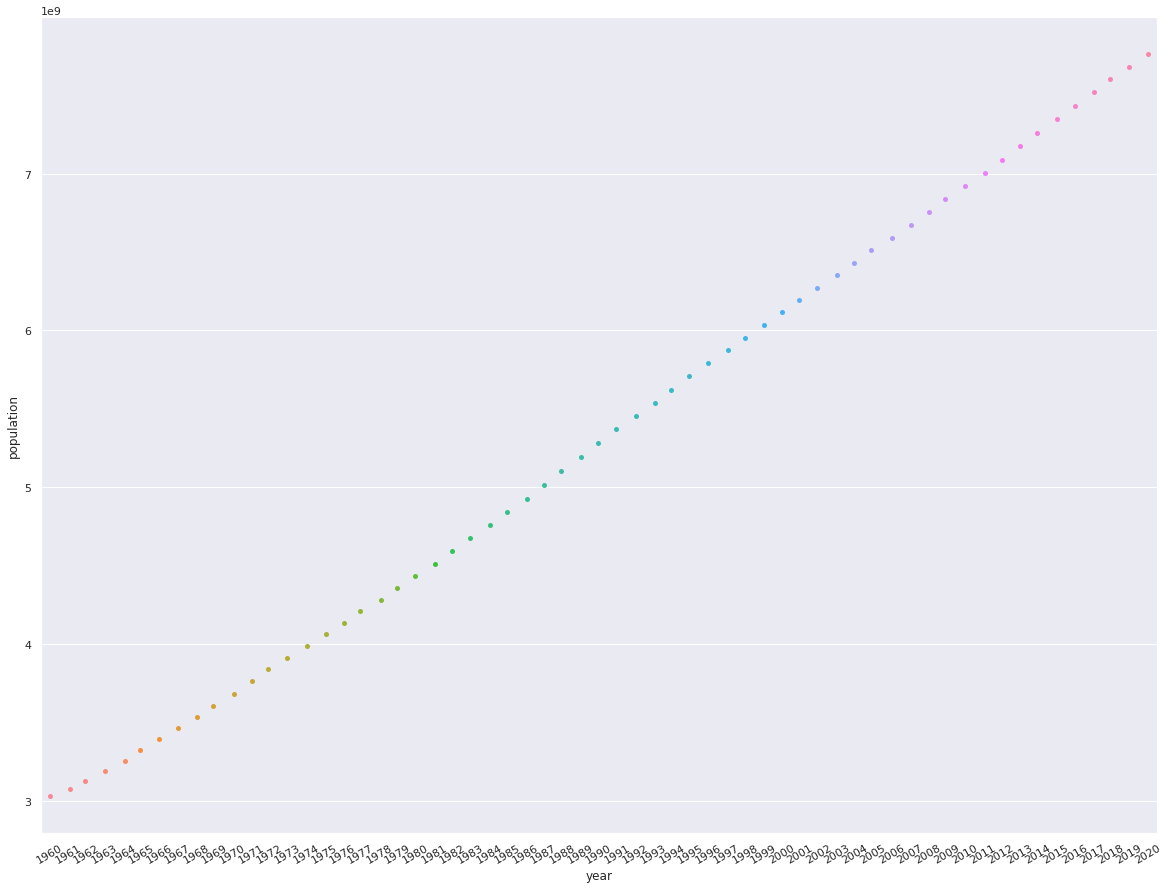

In [50]:

import matplotlib.pyplot as plt
import seaborn as sns

# visualize world population data
sns.set(palette="muted",color_codes=True)
plt.figure(figsize=(20,15))
sns.stripplot(x=world_df['year'],y=world_df['population'],data=world_df,jitter=True)
plt.xticks(rotation=30)



**Prediction Method:** Linear Regression

Linear regression is a simple algorithm that will assume a linear relationship between population and year. It will fit a linear equation to observed data and we can use that equation to predict future years. 

We decided to use linear regression to predict the population because it is a method that is easy to understand and that is compatible with the data we have. We ran linear regression on our historical world population and found that the population projected for 2122 was around 15.9 billion, more than doubling between 2020 and 2122. Given that world population growth rate is on the decline, we figured that this prediction was not reasonable, so we started looking into options to make our projection more realistic.

We decided that instead of using linear regression to predict total world population, we would use it to predict growth rate instead. This should help us capture the trend of slowing population growth in recent years. Using our projected growth rates, we calculated total population for each future year until we reached year 2122 where the population is projected to be about 9.2 billion. 

After taking a closer look at our projected growth rates, we found that annual growth rate started to become negative after year 2080. While some studies show that population in certain countries will begin contracting in the next 100 years, we do not foresee the entire world population declining within that time. Instead, we expect growth to level out, so in order to reflect this, we made one more adjustment to our method: when the projected growth rates started to become negative, we set them to the last positive rate as though growth became constant after that point. When we used this method, we got an estimate of about 10.7 billion by 2122. We think this is our best estimation. 

In [51]:
# calculate historical growth rates
growth_rates = world_df['population'].pct_change()
frames = [world_df['year'], growth_rates]
final = pd.concat(frames, axis=1)
final.dropna(inplace=True)
final = final.rename(columns={'year': 'year', 'population': 'growth rate'})
final.head()

,year,growth rate
1,1961,0.013007
2,1962,0.017243
3,1963,0.020833
4,1964,0.020532
5,1965,0.020552


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59]),
 <a list of 60 Text major ticklabel objects>)

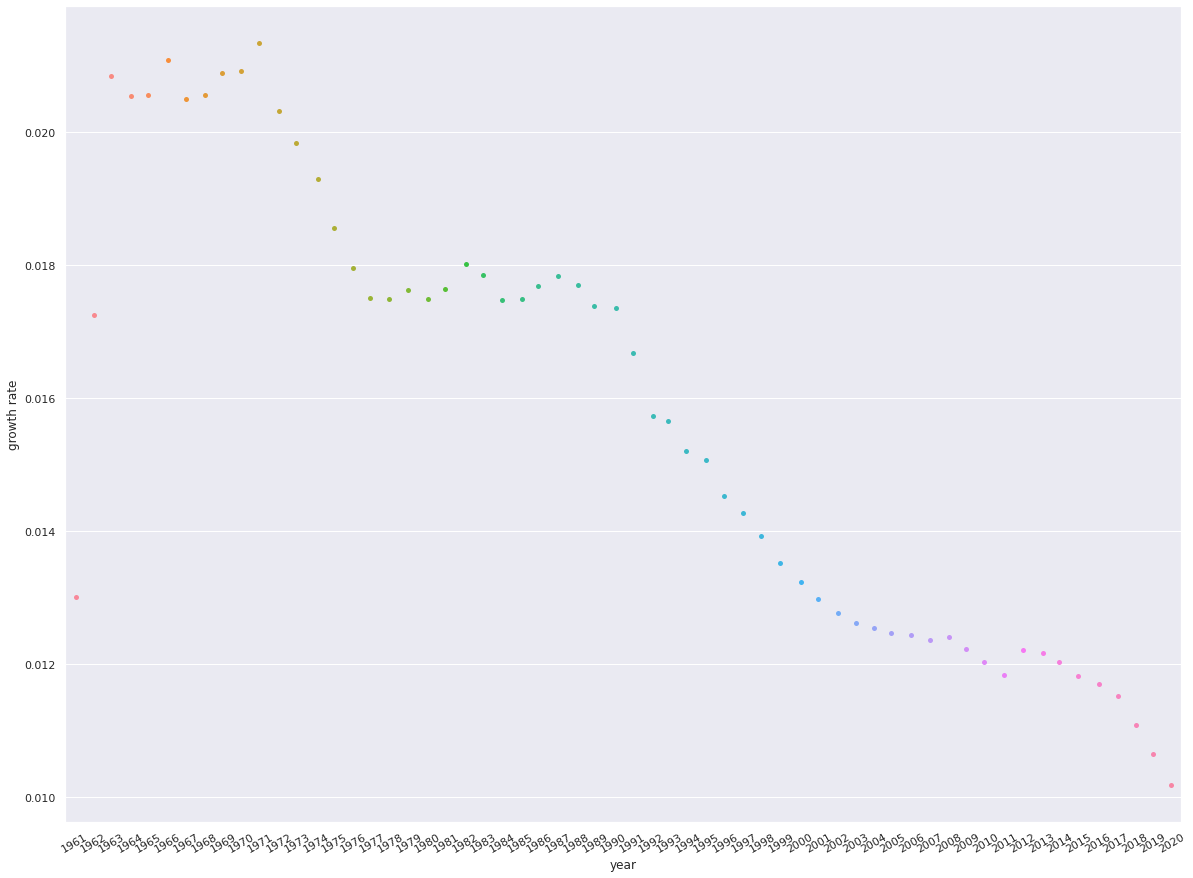

In [52]:
# visualize historical growth rates

sns.set(palette="muted",color_codes=True)
plt.figure(figsize=(20,15))
sns.stripplot(x=final['year'],y=final['growth rate'],data=final,jitter=True)
plt.xticks(rotation=30)

In [53]:
# use linear regression to predict 2122 population

x = final.iloc[:, 0].values.reshape(-1, 1)
y = final.iloc[:, 1].values.reshape(-1, 1)
model = LinearRegression().fit(x, y)

projected_rates = []
projected_populations = []
total_population = world_df.iat[60,1] # retrieve most recent population we have
previous = 0

for x in range(2021, 2122):
  y_pred = model.predict([[x]])
  if y_pred < 0:
    y_pred = previous
  else:
    previous = y_pred
  projected_rates.append(y_pred)
  total_population = total_population * (1 + y_pred)
  projected_populations.append(total_population)

print('The projected world population for 2122 is', total_population)

The projected world population for 2122 is [[1.0713417e+10]]


Text(0, 0.5, 'growth rate')

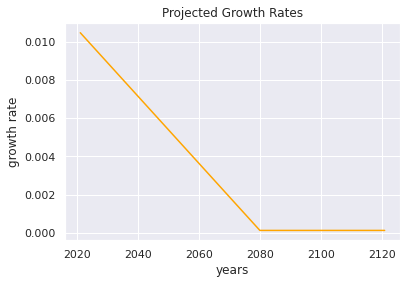

In [56]:
# visualize projections
projected_rates = np.array(projected_rates)
projected_rates = np.squeeze(projected_rates, axis=1)
future_years = np.arange(start=2021, stop=2122, step=1)
plt.plot(future_years, projected_rates, color='orange')
plt.title('Projected Growth Rates')
plt.xlabel('years')
plt.ylabel('growth rate')

Text(0, 0.5, 'world population')

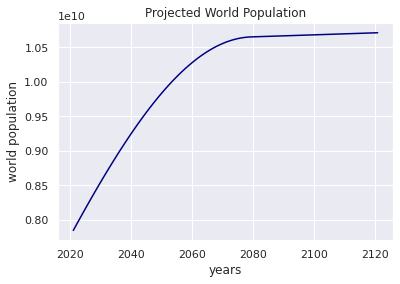

In [58]:
projected_populations = np.array(projected_populations)
projected_populations = np.squeeze(projected_populations, axis=1)
plt.plot(future_years, projected_populations, color='navy')
plt.title('Projected World Population')
plt.xlabel('years')
plt.ylabel('world population')